# ResNet

## Setting

In [ ]:
# rtdl: ResNet, FT-Transformer
!pip install rtdl
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
import rtdl
from typing import Any, Dict

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
# device check
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


In [ ]:
def seed_everything(seed = 21):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
def read_split_data():
    df = pd.read_csv('/content/drive/MyDrive/Data/adult.csv')
    X = {}
    y = {}
    X['train'], X['test'], y['train'], y['test'] = train_test_split(df.iloc[:, :-1], df.income, test_size = 0.10, random_state=21)
    X['train'], X['val'], y['train'], y['val'] = train_test_split(X['train'], y['train'], test_size = 0.10, random_state=21)

    return X, y

In [ ]:
def preprocessing(X, y):
    cat_index = X['train'].select_dtypes(['object']).columns
    num_index = X['train'].select_dtypes(['int64']).columns

    # categorical cardinalities for CategoricalFeatureTokenizer
    cat_cardinalities = []

    # StandardScaler
    ss = StandardScaler()
    X['train'][num_index] = ss.fit_transform(X['train'][num_index])
    X['val'][num_index] = ss.transform(X['val'][num_index])
    X['test'][num_index] = ss.transform(X['test'][num_index])
    # float64 -> float32 (recommended)
    X['train'][num_index] = X['train'][num_index].apply(lambda x: x.astype('float32'))
    X['val'][num_index] = X['val'][num_index].apply(lambda x: x.astype('float32'))
    X['test'][num_index] = X['test'][num_index].apply(lambda x: x.astype('float32'))

    # LabelEncoder
    for col in cat_index:
      le = LabelEncoder()

      X['train'][col] = le.fit_transform(X['train'][col])

      # X_val, X_test에만 존재하는 label이 있을 경우
      for label in np.unique(X['val'][col]):
        if label not in le.classes_:
          le.classes_ = np.append(le.classes_, label)

      for label in np.unique(X['test'][col]):
        if label not in le.classes_:
          le.classes_ = np.append(le.classes_, label)

      X['val'][col] = le.transform(X['val'][col])
      X['test'][col] = le.transform(X['test'][col])

      # cardinalities
      max_cat = np.max([np.max(X['train'][col]),
                        np.max(X['val'][col]),
                        np.max(X['test'][col])]) + 1
      cat_cardinalities.append(max_cat)

    # y = 1 if > 50K
    y['train'] = np.where(y['train']=='>50K', 1, 0).reshape(-1, 1)
    y['val'] = np.where(y['val']=='>50K', 1, 0).reshape(-1, 1)
    y['test'] = np.where(y['test']=='>50K', 1, 0).reshape(-1, 1)

    return X, y, cat_cardinalities

In [ ]:
def setting_rtdl(data, label):
    '''
    DataFrame, np.array -> torch.Tensor
    ResNet: model(X_num, X_cat) / split X -> X_num, X_cat
    '''
    cat_index = data['train'].select_dtypes(['int64']).columns
    num_index = data['train'].select_dtypes(['float32']).columns

    X = {'train': {},
         'val': {},
         'test': {}}
    y = {'train': {},
         'val': {},
         'test': {}}

    X['train']['num'] = torch.tensor(data['train'][num_index].values, device=device)
    X['train']['cat'] = torch.tensor(data['train'][cat_index].values, device=device)

    X['val']['num'] = torch.tensor(data['val'][num_index].values, device=device)
    X['val']['cat'] = torch.tensor(data['val'][cat_index].values, device=device)

    X['test']['num'] = torch.tensor(data['test'][num_index].values, device=device)
    X['test']['cat'] = torch.tensor(data['test'][cat_index].values, device=device)

    # dtype=float for BCELoss
    y['train'] = torch.tensor(label['train'], dtype=torch.float, device=device)
    y['val'] = torch.tensor(label['val'], dtype=torch.float, device=device)
    y['test'] = torch.tensor(label['test'], dtype=torch.float, device=device)

    return X, y

In [ ]:
# Dataset with num / cat features (for rtdl)
class TensorData(Dataset):
    def __init__(self, num, cat, label):
        self.num = num
        self.cat = cat
        self.label = label
        self.len = self.label.shape[0]

    def __getitem__(self, index):
        return self.num[index],self.cat[index], self.label[index]

    def __len__(self):
        return self.len

In [ ]:
def model_train(model, data_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0
    corr = 0

    # for rtdl
    for x_num, x_cat, label in tqdm(data_loader):
        optimizer.zero_grad()

        x_num, x_cat, label = x_num.to(device), x_cat.to(device), label.to(device)
        output = model(x_num, x_cat)
        output = torch.sigmoid(output)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        pred = output >= torch.FloatTensor([0.5]).to(device)
        corr += pred.eq(label).sum().item()
        running_loss += loss.item() * x_num.size(0)

    if scheduler:
        scheduler.step()

    # Average accuracy & loss
    accuracy = corr / len(data_loader.dataset)
    loss = running_loss / len(data_loader.dataset)
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)

    return loss, accuracy

In [ ]:
def model_evaluate(model, data_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        running_loss = 0
        corr = 0

        for x_num, x_cat, label in data_loader:
            x_num, x_cat, label = x_num.to(device), x_cat.to(device), label.to(device)
            output = model(x_num, x_cat)
            output = torch.sigmoid(output)

            pred = output >= torch.FloatTensor([0.5]).to(device)
            corr += pred.eq(label).sum().item()
            running_loss += criterion(output, label).item() * x_num.size(0)

        accuracy = corr / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        history['val_loss'].append(loss)
        history['val_accuracy'].append(accuracy)

        return loss, accuracy

In [ ]:
def model_tune(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()

    # train_loader
    for x_num, x_cat, label in train_loader:
        optimizer.zero_grad()
        x_num, x_cat, label = x_num.to(device), x_cat.to(device), label.to(device)
        output = model(x_num, x_cat)
        output = torch.sigmoid(output)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

    # val_loader
    model.eval()
    with torch.no_grad():
        running_loss = 0
        corr = 0

        for x_num, x_cat, label in val_loader:
            x_num, x_cat, label = x_num.to(device), x_cat.to(device), label.to(device)
            output = model(x_num, x_cat)
            output = torch.sigmoid(output)
            pred = output >= torch.FloatTensor([0.5]).to(device)
            corr += pred.eq(label).sum().item()
            running_loss += criterion(output, label).item() * x_num.size(0)

        val_accuracy = corr / len(val_loader.dataset)
        val_loss = running_loss / len(val_loader.dataset)

        return val_loss, val_accuracy

In [ ]:
def plot_loss(history):
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

def plot_acc(history):
    plt.plot(history['train_accuracy'], label='train', marker='o')
    plt.plot(history['val_accuracy'], label='val',  marker='o')
    plt.title('Accuracy per epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

In [ ]:
# ResNet with Categorical features
class ResNet(nn.Module):
    '''
    <ResNet>: The ResNet model used in [gorishniy2021revisiting].

    ResNet: (in) -> Linear -> Block -> ... -> Block -> Head -> (out)

                   |-> Norm -> Linear -> Activation -> Dropout -> Linear -> Dropout ->|
                   |                                                                  |
           Block: (in) ------------------------------------------------------------> Add -> (out)

            Head: (in) -> Norm -> Activation -> Linear -> (out)

    Examples:
          .. testcode::

              x = torch.randn(4, 2)
              module = ResNet.make_baseline(
                  d_in=x.shape[1],
                  n_blocks=2,
                  d_main=3,
                  d_hidden=4,
                  dropout_first=0.25,
                  dropout_second=0.0,
                  d_out=1
              )
              assert module(x).shape == (len(x), 1)

    n_num_features: # of numeric features
    cat_tokenizer: CategoricalFeatureTokenizer(cardinalities, d_token, bias, initialization)
                   d_token: embedding size, bias = True or False, initialization = 'uniform' or 'normal'
    resnet_kwargs:
              n_blocks: the number of Blocks
              d_main: the input size (or, equivalently, the output size) of each Block
              d_hidden: the output size of the first linear layer in each Block
              dropout_first: the dropout rate of the first dropout layer in each Block.
              dropout_second: the dropout rate of the second dropout layer in each Block.
    '''
    def __init__(self,
                 n_num_features: int,
                 cat_tokenizer: rtdl.CategoricalFeatureTokenizer,
                 resnet_kwargs: Dict[str, Any],):
        super().__init__()
        self.cat_tokenizer = cat_tokenizer
        self.model = rtdl.ResNet.make_baseline(d_in=n_num_features + cat_tokenizer.n_tokens * cat_tokenizer.d_token, **resnet_kwargs,)

    def forward(self, x_num, x_cat):
        return self.model(torch.cat([x_num, self.cat_tokenizer(x_cat).flatten(1, -1)], dim=1))

In [ ]:
def ready_data():
    # data setting
    seed_everything()
    X, y = read_split_data()
    X, y, cardinalities = preprocessing(X, y)
    X, y = setting_rtdl(X, y)

    # dataset, dataloader
    train_data = TensorData(X['train']['num'], X['train']['cat'], y['train'])
    val_data = TensorData(X['val']['num'], X['val']['cat'], y['val'])
    test_data = TensorData(X['test']['num'], X['test']['cat'], y['test'])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

    return X, y, cardinalities, train_loader, val_loader, test_loader

## Run

In [ ]:
X, y, cardinalities, train_loader, val_loader, test_loader = ready_data()

In [ ]:
# categorical embedding dimension = 32
d_token = 32
# hyperparameters
resnet_kwargs = {'n_blocks': 2,
                 'd_main': 64,
                 'd_hidden': 128,
                 'dropout_first': 0.25,
                 'dropout_second': 0.1,
                 'd_out': 1}

resnet = ResNet(n_num_features=X['train']['num'].shape[1],
                cat_tokenizer=rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
                resnet_kwargs=resnet_kwargs).to(device)
print(resnet)

ResNet(
  (cat_tokenizer): CategoricalFeatureTokenizer(
    (embeddings): Embedding(102, 32)
  )
  (model): ResNet(
    (first_layer): Linear(in_features=262, out_features=64, bias=True)
    (blocks): Sequential(
      (0): Block(
        (normalization): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear_first): Linear(in_features=64, out_features=128, bias=True)
        (activation): ReLU()
        (dropout_first): Dropout(p=0.25, inplace=False)
        (linear_second): Linear(in_features=128, out_features=64, bias=True)
        (dropout_second): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
        (normalization): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear_first): Linear(in_features=64, out_features=128, bias=True)
        (activation): ReLU()
        (dropout_first): Dropout(p=0.25, inplace=False)
        (linear_second): Linear(in_features=128, out_features=64, bias=True)
 

In [ ]:
criterion = nn.BCELoss()
# using Adam instead of AdamW(in paper)
optimizer = optim.Adam(resnet.parameters(), lr = 1e-4)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}

EPOCHS = 15
max_loss = np.inf

for epoch in range(EPOCHS):
    train_loss, train_acc = model_train(resnet, train_loader, criterion, optimizer, device, None)
    val_loss, val_acc = model_evaluate(resnet, val_loader, criterion, device)

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(resnet.state_dict(), 'ResNet_Best.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|██████████| 1237/1237 [00:10<00:00, 119.46it/s]


[INFO] val_loss has been improved from inf to 0.33440. Save model.
epoch 01, loss: 0.39882, accuracy: 0.82513, val_loss: 0.33440, val_accuracy: 0.85100 



100%|██████████| 1237/1237 [00:05<00:00, 212.29it/s]


[INFO] val_loss has been improved from 0.33440 to 0.32271. Save model.
epoch 02, loss: 0.33136, accuracy: 0.84639, val_loss: 0.32271, val_accuracy: 0.85350 



100%|██████████| 1237/1237 [00:09<00:00, 132.25it/s]


[INFO] val_loss has been improved from 0.32271 to 0.31843. Save model.
epoch 03, loss: 0.32522, accuracy: 0.84932, val_loss: 0.31843, val_accuracy: 0.85191 



100%|██████████| 1237/1237 [00:17<00:00, 71.52it/s]


epoch 04, loss: 0.32013, accuracy: 0.84985, val_loss: 0.32101, val_accuracy: 0.85214 



100%|██████████| 1237/1237 [00:09<00:00, 125.29it/s]


[INFO] val_loss has been improved from 0.31843 to 0.31757. Save model.
epoch 05, loss: 0.31675, accuracy: 0.85359, val_loss: 0.31757, val_accuracy: 0.85146 



100%|██████████| 1237/1237 [00:07<00:00, 161.32it/s]


[INFO] val_loss has been improved from 0.31757 to 0.31634. Save model.
epoch 06, loss: 0.31858, accuracy: 0.85316, val_loss: 0.31634, val_accuracy: 0.85259 



100%|██████████| 1237/1237 [00:06<00:00, 198.08it/s]


[INFO] val_loss has been improved from 0.31634 to 0.31621. Save model.
epoch 07, loss: 0.31564, accuracy: 0.85511, val_loss: 0.31621, val_accuracy: 0.85441 



100%|██████████| 1237/1237 [00:06<00:00, 177.02it/s]


[INFO] val_loss has been improved from 0.31621 to 0.31278. Save model.
epoch 08, loss: 0.31382, accuracy: 0.85579, val_loss: 0.31278, val_accuracy: 0.85555 



100%|██████████| 1237/1237 [00:05<00:00, 212.71it/s]


epoch 09, loss: 0.31113, accuracy: 0.85698, val_loss: 0.31686, val_accuracy: 0.85555 



100%|██████████| 1237/1237 [00:07<00:00, 167.01it/s]


[INFO] val_loss has been improved from 0.31278 to 0.31170. Save model.
epoch 10, loss: 0.31122, accuracy: 0.85549, val_loss: 0.31170, val_accuracy: 0.85441 



100%|██████████| 1237/1237 [00:05<00:00, 210.14it/s]


epoch 11, loss: 0.31107, accuracy: 0.85607, val_loss: 0.31632, val_accuracy: 0.85305 



100%|██████████| 1237/1237 [00:07<00:00, 166.65it/s]


epoch 12, loss: 0.31153, accuracy: 0.85625, val_loss: 0.31682, val_accuracy: 0.85373 



100%|██████████| 1237/1237 [00:05<00:00, 209.86it/s]


epoch 13, loss: 0.30981, accuracy: 0.85779, val_loss: 0.31836, val_accuracy: 0.85100 



100%|██████████| 1237/1237 [00:06<00:00, 180.14it/s]


epoch 14, loss: 0.30902, accuracy: 0.85812, val_loss: 0.31425, val_accuracy: 0.85350 



100%|██████████| 1237/1237 [00:06<00:00, 190.72it/s]


epoch 15, loss: 0.30704, accuracy: 0.85832, val_loss: 0.31184, val_accuracy: 0.85487 



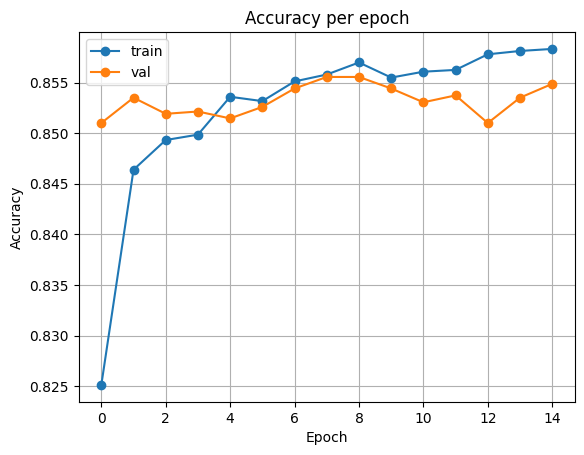

In [ ]:
plot_acc(history)

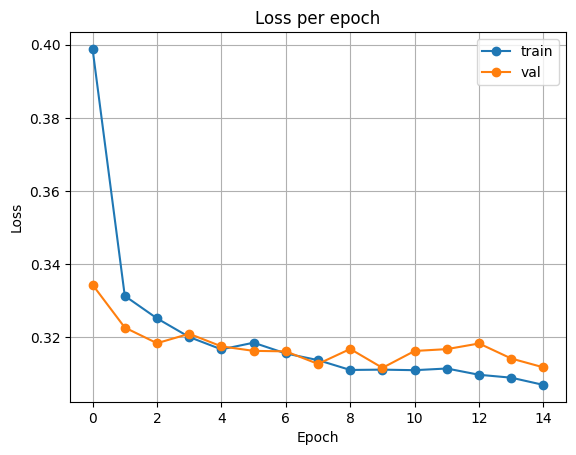

In [ ]:
plot_loss(history)

In [ ]:
# test evaluate
resnet.load_state_dict(torch.load('ResNet_Best.pth'))
test_loss, test_acc = model_evaluate(resnet, test_loader, criterion, device)
print('Test loss:', test_loss, '\nTest acc:', test_acc)

Test loss: 0.31441132257880305 
Test acc: 0.8536335721596725


## Tuning

In [ ]:
X, y, cardinalities, train_loader, val_loader, test_loader = ready_data()

In [ ]:
# optuna objective
# hyperparameter space from Revisiting Deep Learning Models for Tabular Data
# suggest_uniform, suggest_loguniform -> suggest_float, suggest_float(log=True)
def objective(trial, train_loader, val_loader):
    d_token = trial.suggest_int('d_token', 64, 512, log=True)
    resnet_kwargs = {'n_blocks': trial.suggest_int('n_blocks', 1, 8, log=True),
                     'd_main': trial.suggest_int('d_main', 64, 512, log=True),
                     'd_hidden': trial.suggest_int('d_hidden', 64, 2048, log=True),
                     'dropout_first': trial.suggest_float('dropout_first', 0, 0.5),
                     'dropout_second': trial.suggest_float('dropout_second', 0, 0.5),
                     'd_out': 1}
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weigth_decay', 1e-6, 1e-3, log=True)

    model = ResNet(X['train']['num'].shape[1],
                  rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
                  resnet_kwargs).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    EPOCHS = 10
    min_loss = np.inf

    for epoch in range(EPOCHS):
        val_loss, val_acc = model_tune(model, train_loader, val_loader, criterion, optimizer, device)

        if val_loss < min_loss:
            min_loss = val_loss

    # minimize minimun loss
    return min_loss

In [ ]:
study = optuna.create_study(study_name='ResNet', direction='minimize', sampler=TPESampler(seed=21))
study.optimize(lambda trial: objective(trial, train_loader, val_loader), n_trials=15)

print()
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-09-03 14:30:37,482] A new study created in memory with name: ResNet
[I 2023-09-03 14:31:29,227] Trial 0 finished with value: 0.3111502611713045 and parameters: {'d_token': 70, 'n_blocks': 1, 'd_main': 286, 'd_hidden': 68, 'dropout_first': 0.10296138263371951, 'dropout_second': 0.0253866283476884, 'lr': 8.068925058345682e-05, 'weigth_decay': 9.8113977880839e-05}. Best is trial 0 with value: 0.3111502611713045.
[I 2023-09-03 14:32:57,047] Trial 1 finished with value: 0.3124179112249553 and parameters: {'d_token': 121, 'n_blocks': 3, 'd_main': 73, 'd_hidden': 1292, 'dropout_first': 0.06662025962587387, 'dropout_second': 0.08906233077974918, 'lr': 0.00030746001885481724, 'weigth_decay': 0.000390030826829326}. Best is trial 0 with value: 0.3111502611713045.
[I 2023-09-03 14:35:41,597] Trial 2 finished with value: 0.31428985122770914 and parameters: {'d_token': 310, 'n_blocks': 8, 'd_main': 310, 'd_hidden': 241, 'dropout_first': 0.20435916472186627, 'dropout_second': 0.35668021394223


Best Score: 0.30996863016548537
Best trial: {'d_token': 227, 'n_blocks': 2, 'd_main': 500, 'd_hidden': 140, 'dropout_first': 0.09382503031023116, 'dropout_second': 0.08519248250739686, 'lr': 0.0003181781772281558, 'weigth_decay': 8.381275137828959e-05}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
study.best_trial.params

{'d_token': 227,
 'n_blocks': 2,
 'd_main': 500,
 'd_hidden': 140,
 'dropout_first': 0.09382503031023116,
 'dropout_second': 0.08519248250739686,
 'lr': 0.0003181781772281558,
 'weigth_decay': 8.381275137828959e-05}

In [ ]:
X, y, cardinalities, train_loader, val_loader, test_loader = ready_data()

In [ ]:
d_token = study.best_trial.params['d_token']
resnet_kwargs = {'n_blocks': study.best_trial.params['n_blocks'],
                 'd_main': study.best_trial.params['d_main'],
                 'd_hidden': study.best_trial.params['d_hidden'],
                 'dropout_first': study.best_trial.params['dropout_first'],
                 'dropout_second': study.best_trial.params['dropout_second'],
                 'd_out': 1}

resnet = ResNet(n_num_features=X['train']['num'].shape[1],
                cat_tokenizer=rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
                resnet_kwargs=resnet_kwargs).to(device)

criterion = nn.BCELoss()
optimizer = optim.AdamW(resnet.parameters(), lr = study.best_trial.params['lr'], weight_decay=study.best_trial.params['weigth_decay'])

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}

EPOCHS = 15
max_loss = np.inf

for epoch in range(EPOCHS):
    train_loss, train_acc = model_train(resnet, train_loader, criterion, optimizer, device, None)
    val_loss, val_acc = model_evaluate(resnet, val_loader, criterion, device)

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(resnet.state_dict(), 'ResNet_Best_tuned.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|██████████| 1237/1237 [00:08<00:00, 150.61it/s]


[INFO] val_loss has been improved from inf to 0.32505. Save model.
epoch 01, loss: 0.33805, accuracy: 0.84320, val_loss: 0.32505, val_accuracy: 0.84918 



100%|██████████| 1237/1237 [00:06<00:00, 184.00it/s]


[INFO] val_loss has been improved from 0.32505 to 0.31666. Save model.
epoch 02, loss: 0.32212, accuracy: 0.85132, val_loss: 0.31666, val_accuracy: 0.85055 



100%|██████████| 1237/1237 [00:08<00:00, 151.89it/s]


epoch 03, loss: 0.31704, accuracy: 0.85203, val_loss: 0.31921, val_accuracy: 0.84964 



100%|██████████| 1237/1237 [00:06<00:00, 181.44it/s]


[INFO] val_loss has been improved from 0.31666 to 0.31646. Save model.
epoch 04, loss: 0.31728, accuracy: 0.85377, val_loss: 0.31646, val_accuracy: 0.85191 



100%|██████████| 1237/1237 [00:08<00:00, 150.40it/s]


epoch 05, loss: 0.31434, accuracy: 0.85380, val_loss: 0.31839, val_accuracy: 0.85305 



100%|██████████| 1237/1237 [00:06<00:00, 184.34it/s]


epoch 06, loss: 0.31252, accuracy: 0.85511, val_loss: 0.31893, val_accuracy: 0.85282 



100%|██████████| 1237/1237 [00:08<00:00, 151.39it/s]


[INFO] val_loss has been improved from 0.31646 to 0.31143. Save model.
epoch 07, loss: 0.31158, accuracy: 0.85395, val_loss: 0.31143, val_accuracy: 0.85373 



100%|██████████| 1237/1237 [00:06<00:00, 177.75it/s]


epoch 08, loss: 0.30929, accuracy: 0.85632, val_loss: 0.31401, val_accuracy: 0.85669 



100%|██████████| 1237/1237 [00:08<00:00, 152.09it/s]


epoch 09, loss: 0.30777, accuracy: 0.85627, val_loss: 0.31582, val_accuracy: 0.85077 



100%|██████████| 1237/1237 [00:06<00:00, 178.54it/s]


epoch 10, loss: 0.30757, accuracy: 0.85746, val_loss: 0.31208, val_accuracy: 0.85282 



100%|██████████| 1237/1237 [00:08<00:00, 153.30it/s]


epoch 11, loss: 0.30452, accuracy: 0.85903, val_loss: 0.31358, val_accuracy: 0.85487 



100%|██████████| 1237/1237 [00:07<00:00, 173.93it/s]


epoch 12, loss: 0.30536, accuracy: 0.85928, val_loss: 0.31284, val_accuracy: 0.85191 



100%|██████████| 1237/1237 [00:08<00:00, 154.19it/s]


[INFO] val_loss has been improved from 0.31143 to 0.31039. Save model.
epoch 13, loss: 0.30437, accuracy: 0.85784, val_loss: 0.31039, val_accuracy: 0.85714 



100%|██████████| 1237/1237 [00:07<00:00, 176.24it/s]


epoch 14, loss: 0.30356, accuracy: 0.85855, val_loss: 0.31417, val_accuracy: 0.85146 



100%|██████████| 1237/1237 [00:07<00:00, 156.12it/s]


epoch 15, loss: 0.30431, accuracy: 0.85817, val_loss: 0.31190, val_accuracy: 0.85282 



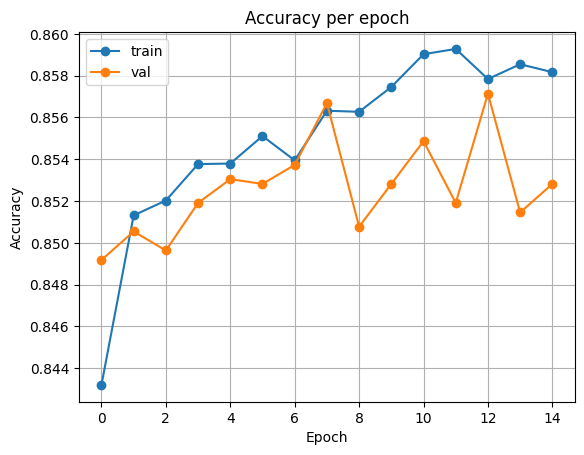

In [ ]:
plot_acc(history)

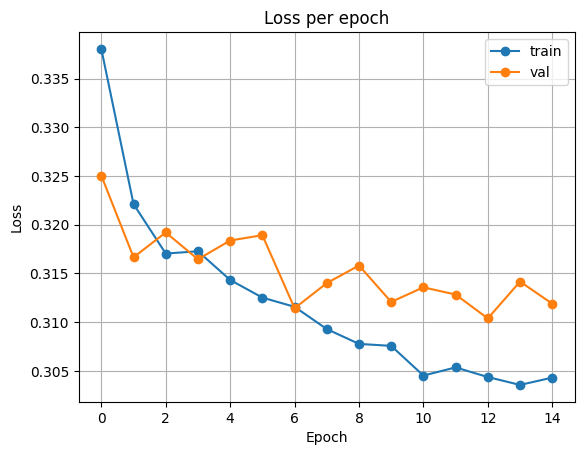

In [ ]:
plot_loss(history)

In [ ]:
# test evaluate
resnet.load_state_dict(torch.load('ResNet_Best_tuned.pth'))
test_loss, test_acc = model_evaluate(resnet, test_loader, criterion, device)
print('Test loss:', test_loss, '\nTest acc:', test_acc)

Test loss: 0.3126100196748087 
Test acc: 0.8562947799385875
